In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

data = pd.read_csv('/content/drive/MyDrive/Traffic.csv')
data.shape


/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


(2976, 9)

In [2]:
data.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


In [4]:
data.describe()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,16.000000,68.696573,14.917339,15.279570,15.324933,114.218414
std,8.945775,45.850693,12.847518,14.341986,10.603833,60.190627
min,1.000000,6.000000,0.000000,0.000000,0.000000,21.000000
25%,8.000000,19.000000,5.000000,1.000000,6.000000,55.000000
50%,16.000000,64.000000,12.000000,12.000000,14.000000,109.000000
75%,24.000000,107.000000,22.000000,25.000000,23.000000,164.000000
max,31.000000,180.000000,70.000000,50.000000,40.000000,279.000000


In [5]:
data.isnull().sum()

,0
Time,0
Date,0
Day of the week,0
CarCount,0
BikeCount,0
BusCount,0
TruckCount,0
Total,0
Traffic Situation,0


# **EDA**

<Axes: xlabel='Day of the week', ylabel='Count'>

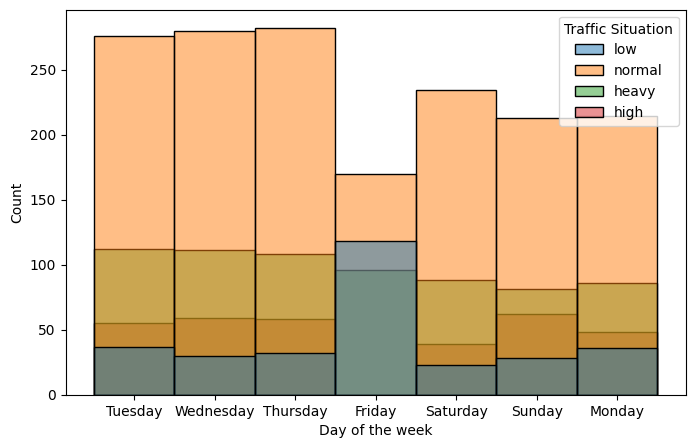

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(data=data, x="Day of the week", hue="Traffic Situation")

<Axes: xlabel='Date', ylabel='Count'>

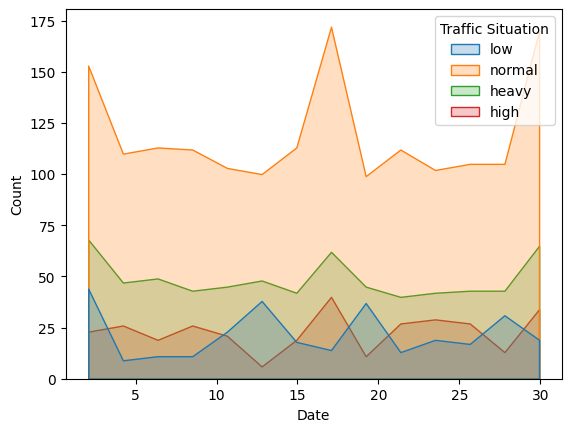

In [7]:
sns.histplot(data, x="Date", hue="Traffic Situation", element="poly")

<Axes: xlabel='Total', ylabel='Count'>

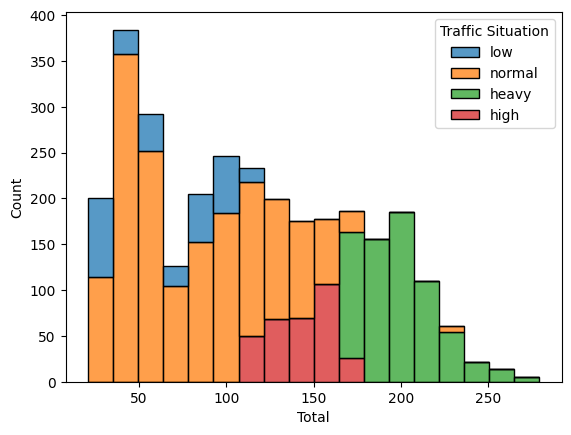

In [8]:
sns.histplot(data=data, x="Total", hue="Traffic Situation", multiple="stack")

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts by Day", "Bike Counts by Day", "Bus Counts by Day", "Truck Counts by Day"))

fig.add_trace(go.Box(x=data['Day of the week'], y=data['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=data['Day of the week'], y=data['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=data['Day of the week'], y=data['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=data['Day of the week'], y=data['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Vehicle Counts by Day of the Week', title_x=0.5, showlegend=False, template='plotly_white', height=600, width=900  )
fig.update_xaxes(title_text="Day of the Week")
fig.update_yaxes(title_text="Count")
fig.show()


In [10]:
import plotly.express as px
fig = px.box(data, x='Traffic Situation', y='Total', title='Total Vehicle Count by Traffic Situation', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Total Vehicle Count by Traffic Situation', title_x=0.5, xaxis_title='Traffic Situation', yaxis_title='Total Count', template='plotly',  height=400, width=700)
fig.show()


In [11]:
numeric_cols = data.select_dtypes(include=['number']).columns

# Group by 'Time' and calculate the mean for numeric columns
avg_time_counts = data.groupby('Time')[numeric_cols].mean().reset_index()

# Create the line plot
fig = px.line(avg_time_counts, x='Time', y=['CarCount', 'BikeCount', 'BusCount', 'TruckCount'], title='Average Vehicle Counts Over Time')
fig.update_layout(title_text='Average Vehicle Counts Over Time', title_x=0.5, xaxis_title='Time', yaxis_title='Average Count', template='plotly_white',  height=500, width=1000)

# Display the plot
fig.show()


# **Prediction**

In [12]:
data.columns

Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation'],
      dtype='object')

In [13]:
data['Traffic Situation'].value_counts()

,count
Traffic Situation,
normal,1669
heavy,682
high,321
low,304


In [14]:
data['Traffic Situation'] = data['Traffic Situation'].replace({'low':0, 'normal':1,
                                                              'heavy':2, 'high':3})

<ipython-input-14-31f771a3db21>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [15]:
data['Day of the week'].value_counts()

,count
Day of the week,
Tuesday,480
Wednesday,480
Thursday,480
Friday,384
Saturday,384
Sunday,384
Monday,384


In [16]:
data['Day of the week'] = data['Day of the week'].replace({'Monday':1,'Tuesday':2,
                                                          'Wednesday':3,'Thursday':4,
                                                          'Friday':5,'Saturday':6,
                                                          'Sunday':7})

<ipython-input-16-852394451377>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [17]:
test_temp = data.copy()
#Extracting Specific time-related information from 'Time(24:00 am/pm)' column

data['hour'] = pd.to_datetime(data['Time']).dt.hour #Hour in separate column
data['minute'] = pd.to_datetime(data['Time']).dt.minute #Minute in separate column


# replace 0 with AM
# replace 1 with PM

data['Temp'] = data['Time'].apply(lambda x: x.split(' ')[1]) #Temporary column for AM/PM
data['AM/PM'] = data['Temp'].replace({'AM':0,'PM':1})

<ipython-input-17-abacb794ba4f>:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-17-abacb794ba4f>:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-17-abacb794ba4f>:12: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [18]:
data= data.drop(columns = ['Time','Temp'], axis=1)
data

,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,hour,minute,AM/PM
0,10,2,31,0,4,4,39,0,0,0,0
1,10,2,49,0,3,3,55,0,0,15,0
2,10,2,46,0,3,6,55,0,0,30,0
3,10,2,51,0,2,5,58,0,0,45,0
4,10,2,57,6,15,16,94,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2971,9,4,16,3,1,36,56,1,22,45,1
2972,9,4,11,0,1,30,42,1,23,0,1
2973,9,4,15,4,1,25,45,1,23,15,1
2974,9,4,16,5,0,27,48,1,23,30,1


In [19]:
data[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'hour', 'minute', 'AM/PM', 'Traffic Situation']].corr()

,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,hour,minute,AM/PM,Traffic Situation
Date,1.000000e+00,-1.672874e-02,-0.013453,-0.005089,-0.015536,0.024734,-0.010679,2.814316e-16,2.865092e-17,6.563367e-17,0.006594
Day of the week,-1.672874e-02,1.000000e+00,-0.002230,0.063583,-0.046031,-0.021895,-0.002953,-2.874150e-16,-5.201713e-17,-1.206884e-16,-0.024423
CarCount,-1.345292e-02,-2.230275e-03,1.000000,0.722539,0.692994,-0.628157,0.970443,1.480863e-01,-3.359952e-03,1.026836e-01,0.541331
BikeCount,-5.088914e-03,6.358283e-02,0.722539,1.000000,0.566364,-0.575399,0.797429,1.405488e-01,-7.978481e-03,1.404737e-01,0.407324
BusCount,-1.553604e-02,-4.603119e-02,0.692994,0.566364,1.000000,-0.546931,0.790705,1.657507e-01,-1.615958e-02,1.209151e-01,0.590153
TruckCount,2.473362e-02,-2.189502e-02,-0.628157,-0.575399,-0.546931,1.000000,-0.555471,-1.695231e-02,-1.119745e-03,9.508203e-05,-0.049809
Total,-1.067861e-02,-2.952752e-03,0.970443,0.797429,0.790705,-0.555471,1.000000,1.793136e-01,-8.310162e-03,1.370317e-01,0.631150
hour,2.814316e-16,-2.874150e-16,0.148086,0.140549,0.165751,-0.016952,0.179314,1.000000e+00,-1.003662e-17,8.667781e-01,0.175062
minute,2.865092e-17,-5.201713e-17,-0.003360,-0.007978,-0.016160,-0.001120,-0.008310,-1.003662e-17,1.000000e+00,-6.691275e-18,0.002993
AM/PM,6.563367e-17,-1.206884e-16,0.102684,0.140474,0.120915,0.000095,0.137032,8.667781e-01,-6.691275e-18,1.000000e+00,0.124653


<Axes: >

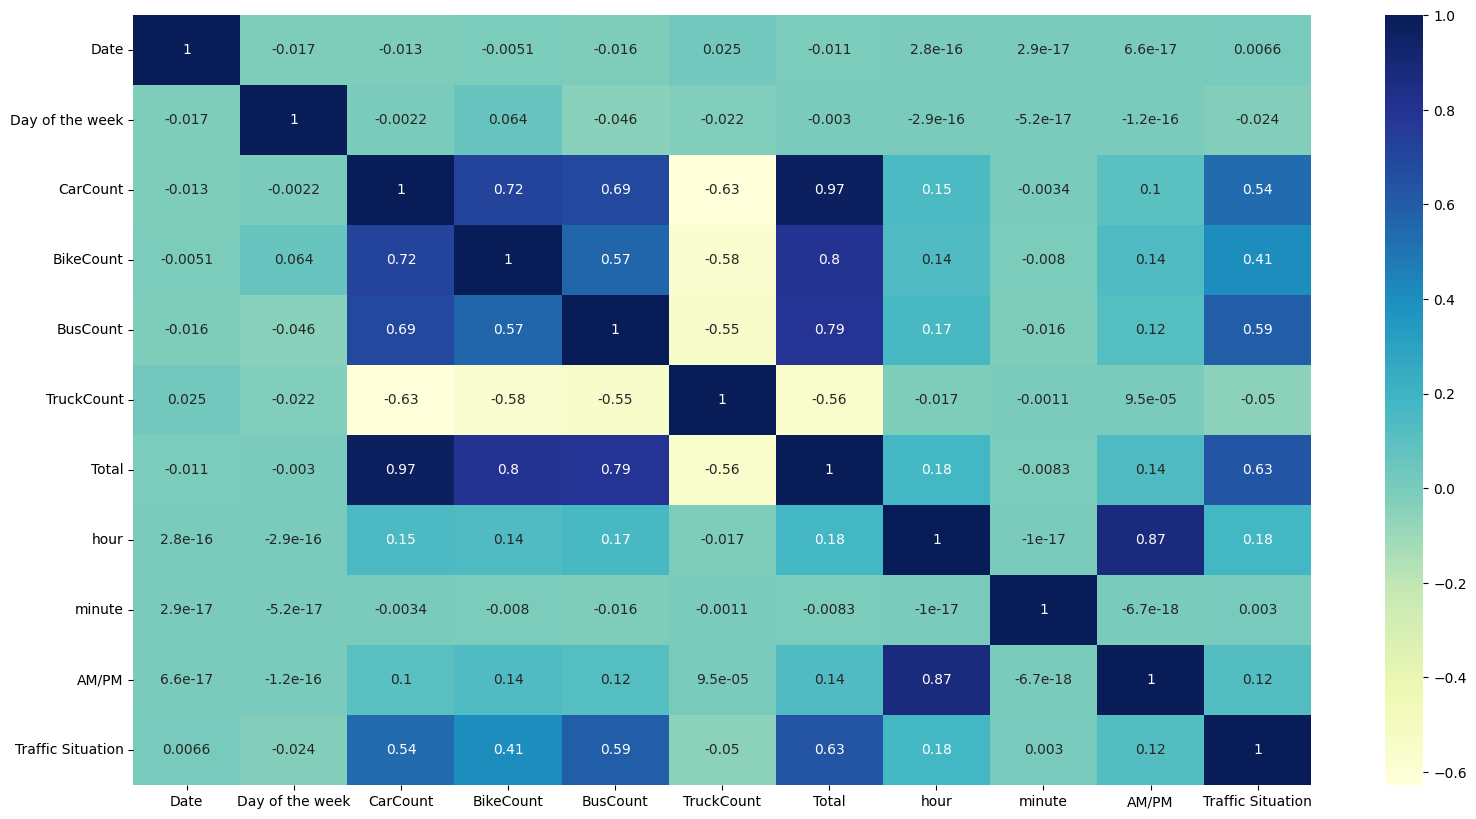

In [20]:
plt.figure(figsize = (19,10))
sns.heatmap(data[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
           'TruckCount', 'Total', 'hour', 'minute', 'AM/PM', 'Traffic Situation']].corr(),
            cmap="YlGnBu",annot=True)

In [21]:
data.columns

Index(['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation', 'hour', 'minute', 'AM/PM'],
      dtype='object')

In [22]:
X= data[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total','hour', 'minute', 'AM/PM']]

y= data['Traffic Situation'].values

In [23]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2 , random_state = 0)

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

In [25]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [30]:
c1 = LogisticRegression()
c2 = RandomForestClassifier()
c3 = SVC(probability=True)

c4 = AdaBoostClassifier()
c1 = LogisticRegression()
c2 = RandomForestClassifier()
c3 = SVC(probability=True)

c4 = AdaBoostClassifier()

voting_cl = VotingClassifier(estimators = [('LR',c1),('RF',c2),('SVC',c3),('ADA',c4)], voting = 'hard')

voting_cl.fit(train_X, train_y)



VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('RF', RandomForestClassifier()),
                             ('SVC', SVC(probability=True)),
                             ('ADA', AdaBoostClassifier())])

In [31]:
voting_pred = voting_cl.predict(test_X)

accuracy = accuracy_score(test_y, voting_pred)

In [32]:
accuracy

0.9161073825503355

In [33]:
for clf, label in zip([c1,c2,c3,c4,c5],['lr','rf','svc','xgb','ada']):
    scores = cross_val_score(clf, train_X, train_y, scoring='accuracy', cv=5)
    print('Accuracy: ', (scores.mean(), label))

Accuracy:  (0.8987394957983194, 'lr')
Accuracy:  (0.9945378151260504, 'rf')
Accuracy:  (0.9147058823529411, 'svc')
Accuracy:  (0.7773109243697479, 'xgb')
Accuracy:  (0.7773109243697479, 'ada')


In [34]:
#RF
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(train_X, train_y)

rfc_pred = rfc.predict(test_X)
accuracy = accuracy_score(test_y, rfc_pred)
accuracy

0.9966442953020134

In [36]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_y, xgbc_pred)
conf_matrix

array([[ 64,   0,   0,   0],
       [  0, 334,   0,   0],
       [  0,   0, 138,   0],
       [  0,   0,   0,  60]])

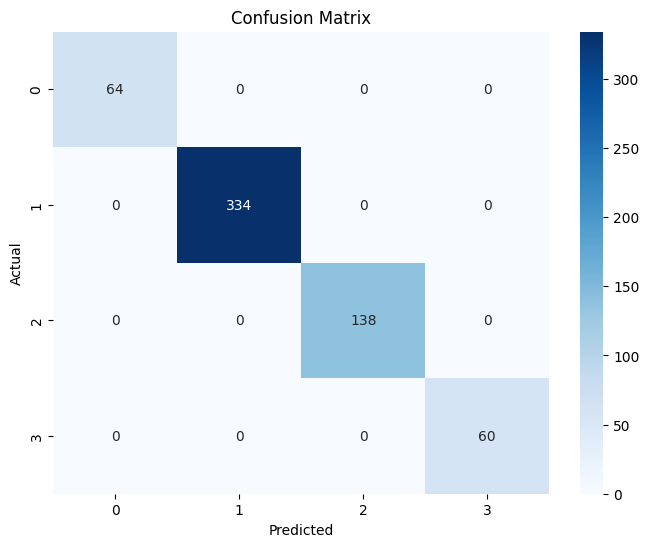

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
